In [3]:
# ruff: noqa: N802, N803, N806, N815, N816
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

import archimedes as arc

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

# Generating C code

The first step on the road to deployment is understanding the process of translating your Python logic into C code.

First, let's write our Python function.  In this example we'll be working with an "infinite impulse response" (IIR) filter in the form of a difference equation:

$$
y_n = \sum_{i=0}^{N_n} b_i u_{n-i} - \sum_{i=1}^{N_d} a_i y_{n-i}
$$

The idea is that we can use Python ecosystem tools like `scipy.signal` for filter design and testing on reference signals, and then quickly deploy updated filters to a microcontroller.

Here's a basic implementation of the IIR difference equation:

In [55]:
@arc.compile
def iir_filter(u, b, a, u_prev, y_prev):
    # Update input history
    u_prev[1:] = u_prev[:-1]
    u_prev[0] = u

    # Compute output using the direct II transposed structure
    y = (np.dot(b, u_prev) - np.dot(a[1:], y_prev[:len(a)-1])) / a[0]
    
    # Update output history
    y_prev[1:] = y_prev[:-1]
    y_prev[0] = y
    
    return u_prev, y_prev


There are a couple of things to note about this implementation.

- It does not hardcode any values for the length of the arrays (filter order)
- It is "functionally pure", meaning that all outputs are direct functions of the inputs

Writing it to be general regardless of array length means we can experiment with different filter orders without rewriting any C code.  The pure form allows the function to be traced symbolically (since there are no side effects) and also means the function mimics the logic that the C code will follow in order to pre-allocate all memory.  

This is an important potentially counterintuitive point; typically when optimizing pure NumPy code you might pre-allocate "buffer" arrays to avoid as much dynamic memory allocation as possible.  With Archimedes, you do not need to (and in fact cannot) do this.  Instead, the code generation system determines memory handling for you.  We'll see what this looks like shortly.  This helps to separate the mathematical logic of a function from its implementation detail.

Next we can use SciPy's tools to design filter coefficients:

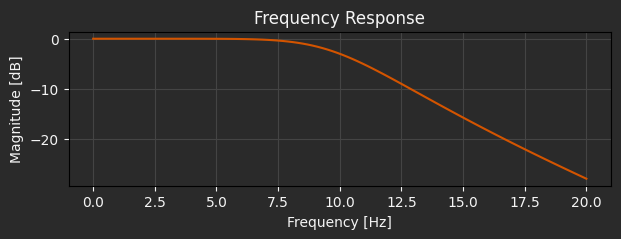

In [61]:
dt = 0.01  # Sampling time [seconds]
Wn = 10  # Cutoff frequency [Hz]
order = 4
b, a = signal.butter(order, Wn, 'low', analog=False, fs=1/dt)

# Plot the frequency response
w = np.linspace(0, 2*Wn, 100)
_, h = signal.freqz(b, a, worN=w, fs=1/dt)
plt.figure(figsize=(7, 2))
plt.plot(w, 20 * np.log10(abs(h)))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('Frequency Response')
plt.grid()
plt.show()

Before proceeding with code generation, it is wise to check that the Python function does what it is intended to.  In this case we can compare the step response as calculated by `iir_filter` to the one calculated by `scipy.signal.lfilter`.  If these match, we can be confident that our code is working properly.  More generally, you might want to implement some simulation code and a set of unit tests to comprehensively test your Python code before converting to C.

Step response matches: True


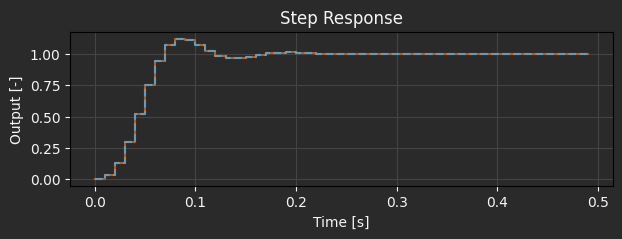

In [62]:
# Apply the IIR filter to a step input
u = np.ones(50)
t = np.arange(len(u)) * dt

u_prev = np.zeros(len(b))
y_prev = np.zeros(len(a)-1)
y = np.zeros_like(u)
for i in range(len(y)):
    u_prev, y_prev = iir_filter(u[i], b, a, u_prev, y_prev)
    y[i] = y_prev[0]


# SciPy filter function
y_sp = signal.lfilter(b, a, u)

print("Step response matches:", np.allclose(y, y_sp))

plt.figure(figsize=(7, 2))
plt.step(t, y, label='Archimedes', where='post')
plt.step(t, y_sp, '--', label='SciPy', where='post')
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Output [-]')
plt.title('Step Response')
plt.show()